<a href="https://colab.research.google.com/github/isidora00/MU_Wine_Predictions/blob/main/Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predviđanje vrste i kvaliteta vina iz njegovih fizičkih svojstava

Kvalitet vina je ključan za konzumere kao i za proizvođače u vinskoj industriji. Sertifikacija kvaliteta proizvoda postaje sve važnija za povećanje tržišne vrednosti i prodaje. Tradicionalno, testiranje kvaliteta vina vrši se na kraju proizvodnog procesa, što je vremenski zahtevno i resursno intenzivno. Ovaj pristup zahteva angažovanje brojnih stručnjaka za procenu, što može biti skupo i subjektivno, s obzirom na različite mišljenja i standarde procene.

Kako bi se poboljšala efikasnost i tačnost u proceni kvaliteta vina, možemo koristiti objektivne metode koje mogu smanjiti zavisnost od ljudskih procena. Različite karakteristike vina mogu uticati na njegov kvalitet, ali nisu sve od njih relevantne za precizno predviđanje.
U ovom projektu koristimo mašinsko učenje da bismo identifikovali ključne karakteristike vina i omogućili preciznije i efikasnije ocenjivanje njegovog kvaliteta.

## Skup podataka
Skup podataka koji ćemo koristiti za ovaj problem je javno dostupan na sledećem linku https://archive.ics.uci.edu/dataset/186/wine+quality. Ovaj skup podataka sadrži 6497 primeraka portugalskog vina *vinho verde*. Podaci su nebalansirano raspodeljeni između dve vrste vina: 75% uzoraka su bela vina (4898), dok 25% čine crvena vina (1599). Svaki uzorak je opisan sa 11 fizičko-hemijskih karakteristika, koje su sve neprekidne veličine: fiksna kiselost, hlapiva kiselost, koncentracija limunske kiseline, sadržaj rezidualnog šećera, koncentracije hlorida, sadržaj slobodnog sumpor-dioksida, ukupan sadržaj sumpor-dioksida, gustina, pH, koncentracije sulfata i sadržaj alkohola. Svakom uzorku dodeljene su i dve oznake: stil vina (crveno ili belo) i subjektivna ocena (celi brojevi između 0 i 10) koju je odredio panel od tri somelijera.

In [1]:
pip -q install seaborn ucimlrepo imbalanced-learn plotly

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, model_selection, metrics
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import plotly.graph_objects as go

In [3]:
# Fetch dataset
wine_quality = fetch_ucirepo(id=186)
print(wine_quality.variables)
df = wine_quality.data

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non


Vidimo da nemamo nedostajuće vrednosti ni u jednoj koloni. Sledi kratak opis svih raspoloživih karakteristika vina:
- **fixed_acidity**: Nehlapljive kiseline koje se ne isparavaju lako.
- **volatile_acidity**: Visoka koncentracija octene kiseline u vinu koja može dovesti do neprijatnog ukusa sirćeta.
- **citric_acid**: Deluje kao konzervans koji povećava kiselost. U malim količinama, dodaje svežinu i ukus vinima.
- **residual_sugar**: Količina šećera koja ostaje nakon što fermentacija završi. Ključno je postići savršen balans između slatkoće i kiselosti. Važno je napomenuti da vina sa više od 45 g/l su slatka.
- **chlorides**: Količina soli u vinu.
- **free_sulfur_dioxide**: Sprečava rast mikroba i oksidaciju vina.
- **total_sulfur_dioxide**: Količina slobodnih i vezanih oblika SO2.
- **density**: Slađa vina imaju veću gustinu.
- **pH**: Opisuje nivo kiselosti na skali od 0 do 14. Većina vina se kreće između 3 i 4 na pH skali.
- **sulphates**: Dodatak u vinu koji doprinosi nivou SO2 i deluje kao antimikrobni i antioksidantni agent.
- **alcohol**: Prisutan u malim količinama u vinima.

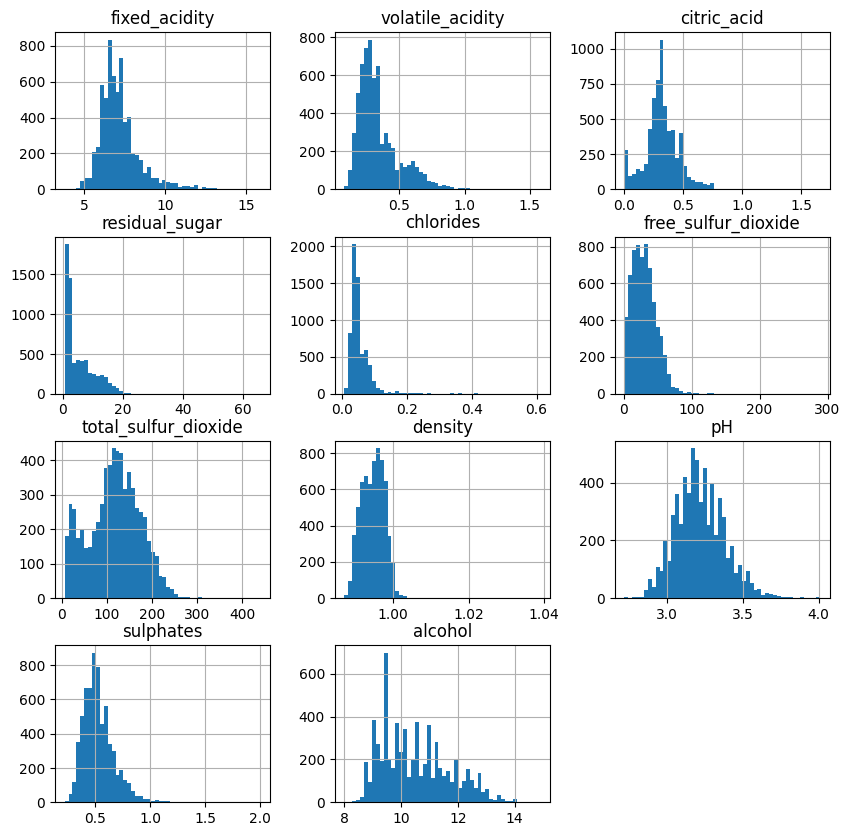

In [4]:
df.features.hist(figsize=(10,10),bins=50)
plt.show()

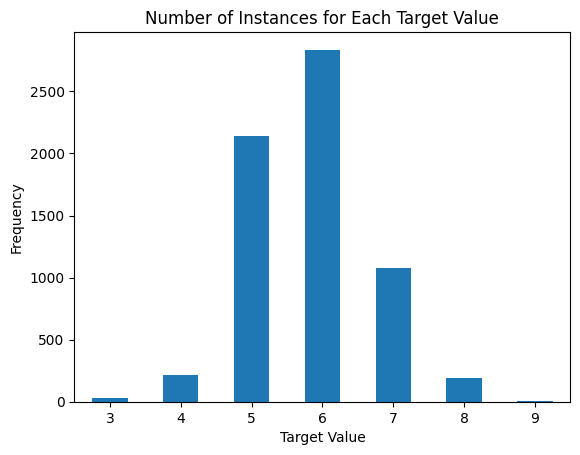

In [5]:
value_counts = df.targets.value_counts().sort_index()
# Plot
ax = value_counts.plot(kind='bar')

ax.set_xticklabels([x[0] for x in value_counts.index] )
plt.xlabel('Target Value')
plt.ylabel('Frequency')      #
plt.title('Number of Instances for Each Target Value')
plt.xticks(rotation=0)
plt.show()

### Selekcija atributa

Selekcija atributa je tehnika koja omogućava odabir najboljeg skupa atributa za modeliranje i predviđanje. Cilj je identifikovati koji atributi donose najviše informacija i time poboljšati performanse modela.

Koristimo koeficijente korelacije između svih parova atributa u skupu podataka. Korelacija meri kako su atributi međusobno povezani:

Vrednost 1 označava jaku pozitivnu linearnu korelaciju, vrednost -1 označava jaku negativnu korelaciju dok vrednost 0 ukazuje na odsustvo korelacije, što znači da ne postoji značajna povezanost između atributa.

Na primer, atributi poput fiksne kiselosti i gustine imaju visoku korelaciju sa koeficijentom od 0.46, što sugeriše da su ti atributi značajno povezani. Nasuprot tome, atributi kao što su hloridi i koncentracija limunske kiseline imaju nižu korelaciju sa koeficijentom od 0.04, što znači da su manje povezani.

Razumevanje ovih korelacija može pomoći u optimizaciji modela tako što ćemo eliminisati redundantne ili manje korisne atributa.

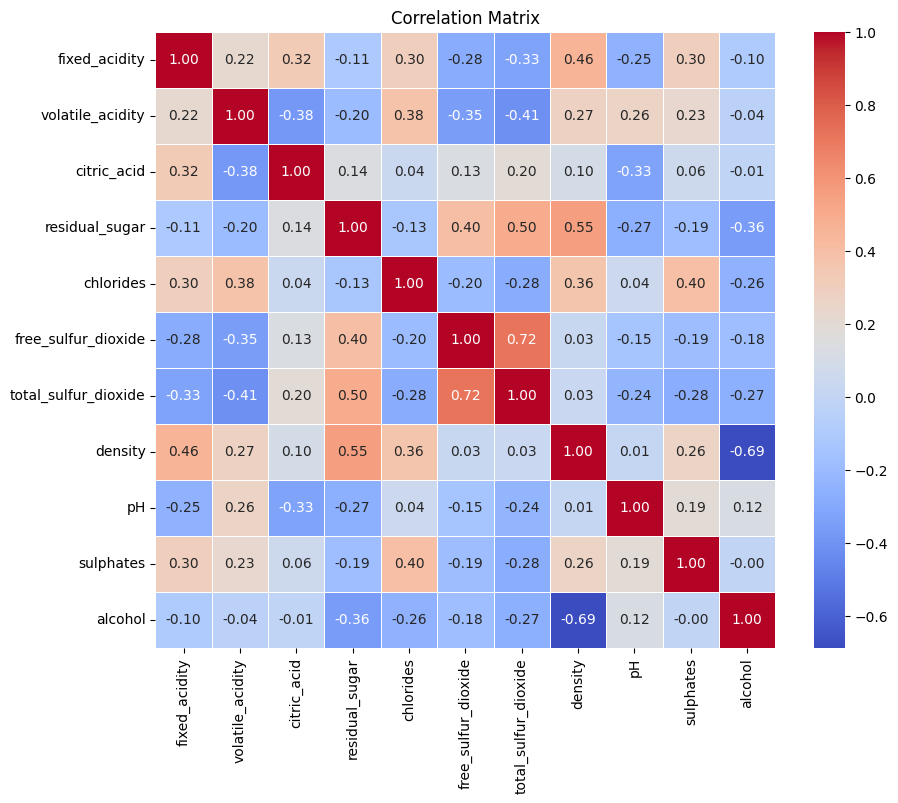

In [6]:
correlation_matrix = df.features.corr() # koefcijijenti korelacija atributa
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5) # toplotna mapa za prikaz koeficijenata
plt.title('Correlation Matrix')
plt.show()

## Pretprocesiranje podataka
### Podela podataka na skup za obučavanje i skup za testiranje
Na samom početku podatke delimo na skup za obučavanje i skup za testiranje koji sadrži 25% podataka i koji neće učestvovati u treniranju modela.

In [7]:
# Podela na trening, validacioni i test skup
X = df.features
y = df.targets
X_train_validation, X_test, y_train_validation, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=42, stratify=y_train_validation)
y_train = np.array(y_train).ravel()
y_train_validation = np.array(y_train_validation).ravel()
y_val = np.array(y_val).ravel()
y_test = np.array(y_test).ravel()

## Standardizacija atributa
Sledeći korak je standardizacija atributa. Bitna napomena je da skalare za standardizaciju učimo na skupu za treniranje, dok skaliranje primenjujemo i na test skupu.

In [8]:
# Standardizacija atributa
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### Redukcija dimenzionalnosti
Za sve metode koje ćemo koristiti, primenićemo tehniku redukcije dimenzionalnosti. Ova tehnika je korisna za smanjenje broja atributa u podacima, čime se poboljšava efikasnost modela, smanjuje složenost i potencijalno otklanjaju redudantni podaci. Dimenzija na koju ćemo redukovati podatke biće definisana kao hiperparametar modela, što znači da će se optimizovati tokom procesa obuke modela kako bi se postigao najbolji rezultat.

## Modeli

Na modelima linearne regresije, slučajne šume, svm, naive-bayes i adaboost-a ćemo unakrsnom validacijom na trening skupu naći najbolje hiperparametre, parametre i ocene rada modela. Na osnovu tih ocena, izabraćemo najbolji model i njega evaluirati konačno na test skupu.

Koristićemo PCA za smanjenje dimenzionalnosti podataka i GridSearchCV za optimizaciju modela, s obzirom na to da imamo ograničen broj podataka.

### Linearna regresija

In [9]:
# Hiperparametri
pipeline_lr = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('regressor', linear_model.LinearRegression())
])

param_grid_lr = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
}

In [10]:
# Unakrsna validacija na trening skupu
grid_search_lr = model_selection.GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best score for Linear Regression: ", grid_search_lr.best_score_)
print("Best parameters for Linear Regression: ", grid_search_lr.best_params_)

Best score for Linear Regression:  -0.5501072067227317
Best parameters for Linear Regression:  {'pca__n_components': 11}


In [11]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_lr = grid_search_lr.best_estimator_
y_val_pred_lr = best_model_lr.predict(X_val)

In [12]:
# Iscrtavanje tačnih i predviđenih vrednosti
def plot_predicted_actual_values(y,y_pred):

    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5, color='blue', edgecolors='k', s=50)

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')

    plt.grid(True)
    plt.show()

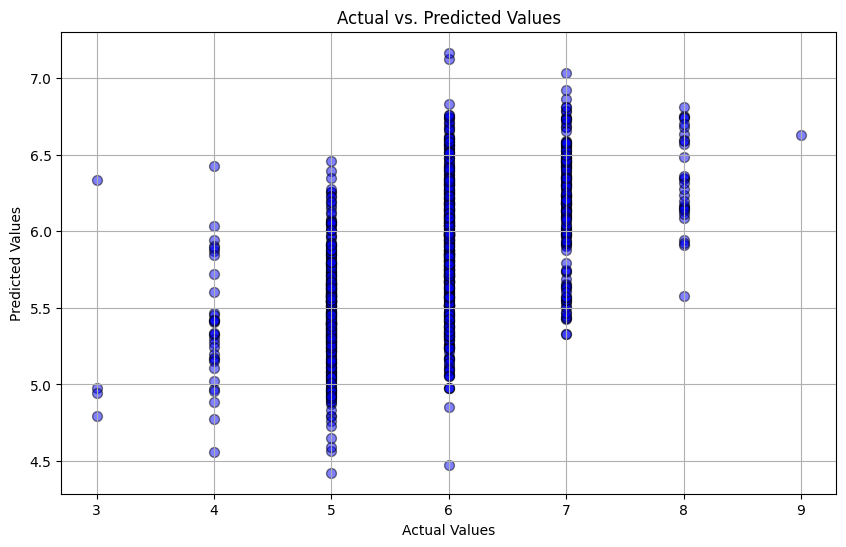

In [13]:
plot_predicted_actual_values(y_val,y_val_pred_lr)

In [14]:
models = []
# Ispis grešaka za model
def print_errors(y, y_pred, model_name):
    # Mean Squared Error
    mse = metrics.mean_squared_error(y, y_pred)
    print("Mean Squared Error: ", mse)

    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y, y_pred)
    print("Mean Absolute Error: ", mae)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: ", rmse)

    # R-squared
    r2 = metrics.r2_score(y, y_pred)
    print("R-squared: ", r2)

    # Median Absolute Error
    median_ae = metrics.median_absolute_error(y, y_pred)
    print("Median Absolute Error: ", median_ae)

    # Explained Variance Score
    explained_variance = metrics.explained_variance_score(y, y_pred)
    print("Explained Variance Score: ", explained_variance)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print("Mean Absolute Percentage Error: {:.2f}%".format(mape))

    model = {
        'Model' : model_name,
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Median_AE': median_ae, 'Explained_Variance': explained_variance, 'MAPE': mape
    }

    return model

In [15]:
# Testiranje dobijenog modela na validacionom skupu
print("Linear regression model errors on validation set: ")
model_lr = print_errors(y_val,y_val_pred_lr,'LR')
models = models + [model_lr]

Linear regression model errors on validation set: 
Mean Squared Error:  0.5081251092515632
Mean Absolute Error:  0.5558482931532515
Root Mean Squared Error:  0.7128289481015506
R-squared:  0.3313671306846573
Median Absolute Error:  0.4762040311262714
Explained Variance Score:  0.3322047489819354
Mean Absolute Percentage Error: 9.81%


### Naive-Bayes

In [16]:
# Hiperparametri
pipeline_nb = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('classifier', GaussianNB())
])

param_grid_nb = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
}

In [17]:
# Unakrsna validacija
grid_search_nb = model_selection.GridSearchCV(pipeline_nb, param_grid_nb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)
best_model_nb = grid_search_nb.best_score_

print("Best cross-validation score for Naive-Bayes: ",best_model_nb)
print("Best parameters for Naive-Bayes: ", grid_search_nb.best_params_)

Best cross-validation score for Naive-Bayes:  -0.7454452142673852
Best parameters for Naive-Bayes:  {'pca__n_components': 9}


In [18]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_nb = grid_search_nb.best_estimator_
y_val_pred_nb = best_model_nb.predict(X_val)

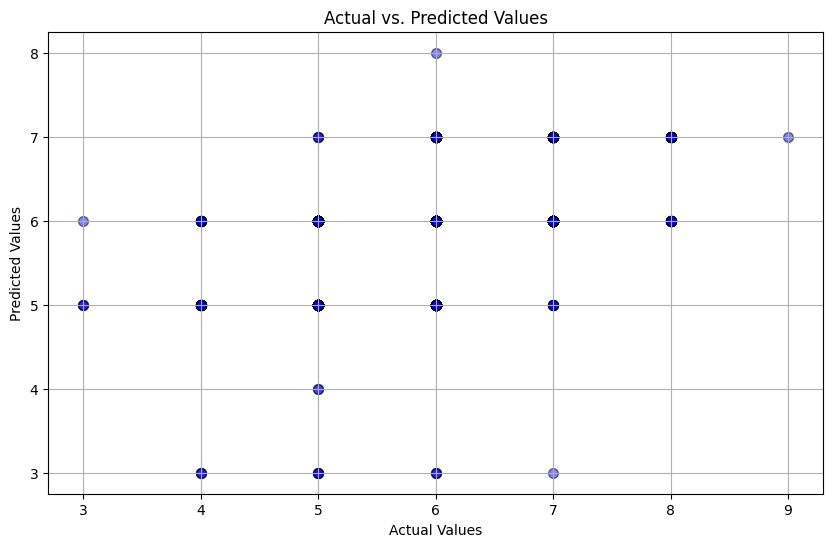

In [19]:
plot_predicted_actual_values(y_val,y_val_pred_nb)

In [20]:
# Testiranje dobijenog modela na validacionom skupu
print("Naive-Bayes model errors on validation set: ")
model_nb = print_errors(y_val,y_val_pred_nb, 'NB')
models = models + [model_nb]

Naive-Bayes model errors on validation set: 
Mean Squared Error:  0.6646153846153846
Mean Absolute Error:  0.5415384615384615
Root Mean Squared Error:  0.8152394645841089
R-squared:  0.12544433739742888
Median Absolute Error:  0.0
Explained Variance Score:  0.12669014318461191
Mean Absolute Percentage Error: 9.60%


## SVR

In [21]:
# Hiperparametri
pipeline_svr = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('svr', SVR())
])

param_grid_svr = {
    'pca__n_components': [8, 9, 10, 11],
    'svr__C': [0.01 ,0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 1],
    'svr__gamma' : ['scale','auto']
}

In [22]:
# Unakrsna validacija
grid_search_svr = model_selection.RandomizedSearchCV(pipeline_svr, param_grid_svr, n_iter = 50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train, y_train)
best_model_svr = grid_search_svr.best_score_

print("Best cross-validation score for SVR: ",best_model_svr)
print("Best parameters for SVR: ", grid_search_svr.best_params_)

Best cross-validation score for SVR:  -0.4810794523690882
Best parameters for SVR:  {'svr__gamma': 'scale', 'svr__epsilon': 0.2, 'svr__C': 1, 'pca__n_components': 11}


In [23]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_svr = grid_search_svr.best_estimator_
y_val_pred_svr = best_model_svr.predict(X_val)

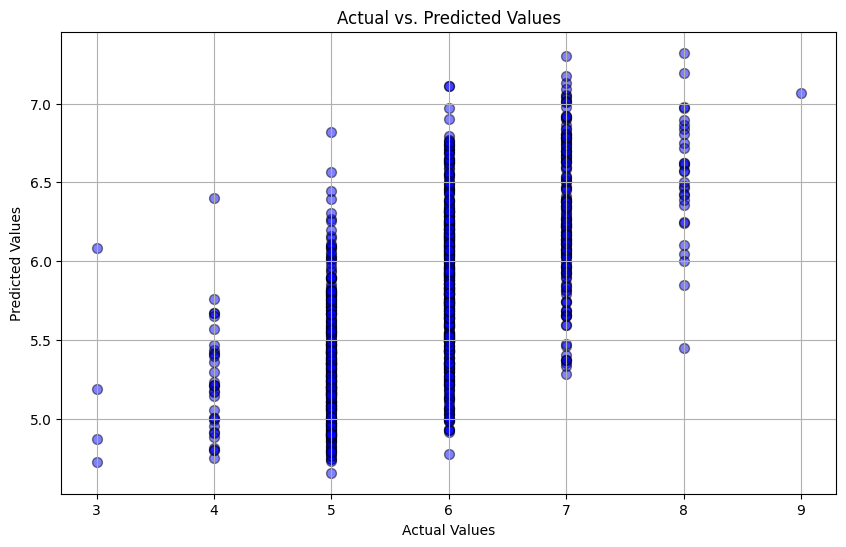

In [24]:
plot_predicted_actual_values(y_val,y_val_pred_svr)

### Provera parametara na toplotnoj mapi
S obzirom na to da imamo četiri hiperparametara, projekcija ukupne toplotne mape na dva parametra nije dovoljno informativna. Umesto toplotnih mapa možemo koristiti metodu za iscrtavanje paralelnih koordinata. Ova metoda omogućava vizualizaciju više hiperparametara zajedno kako bi se lakše analizirale njihove interakcije i uticaj na performanse modela.

Takođe, s obzirom na to da je pretraga hiperparametara randomizovana, neke od vrednosti mogu biti nedostupne.

In [25]:
import plotly.express as px

cv_results = pd.DataFrame(grid_search_svr.cv_results_)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

df = cv_results.rename(columns=shorten_param)

fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['mean_test_score'],
            colorscale='Viridis',
            showscale=True
        ),
        dimensions = list([
            dict(range = [8,11],
                label = 'n_components', values = df['n_components']),
            dict(range= [0.01,100],
                 label='C', values = df['C']),
            dict(range = [0.01,1],
                label = 'epsilon', values = df['epsilon'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [26]:
# Testiranje dobijenog modela na validacionom skupu
print("SVR model errors on validation set: ")
model_svr = print_errors(y_val,y_val_pred_svr,'SVR')
models = models + [model_svr]

SVR model errors on validation set: 
Mean Squared Error:  0.4495257705211697
Mean Absolute Error:  0.5143823089659056
Root Mean Squared Error:  0.6704668302915289
R-squared:  0.4084769669865801
Median Absolute Error:  0.3974041868410465
Explained Variance Score:  0.4121918334964916
Mean Absolute Percentage Error: 9.04%


## Slučajna šuma

In [27]:
# Hiperparametri
pipeline_rf = Pipeline([
    ('scalar',StandardScaler()),
    ('pca', PCA()),
    ('regressor', RandomForestRegressor())
])

param_grid_rf = {
    'pca__n_components': [8, 9, 10, 11],
    'regressor__n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20, 30, 50, 100],  # Maximum depth of the trees
    'regressor__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'regressor__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
}

In [28]:
# Unakrsna validacija
grid_search_rf = model_selection.RandomizedSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_score_

print("Best cross-validation score for Random Forest: ",best_model_rf)
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)

Best cross-validation score for Random Forest:  -0.45330877128411706
Best parameters for Random Forest:  {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None, 'pca__n_components': 9}


In [29]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_rf = grid_search_rf.best_estimator_
y_val_pred_rf = best_model_rf.predict(X_val)

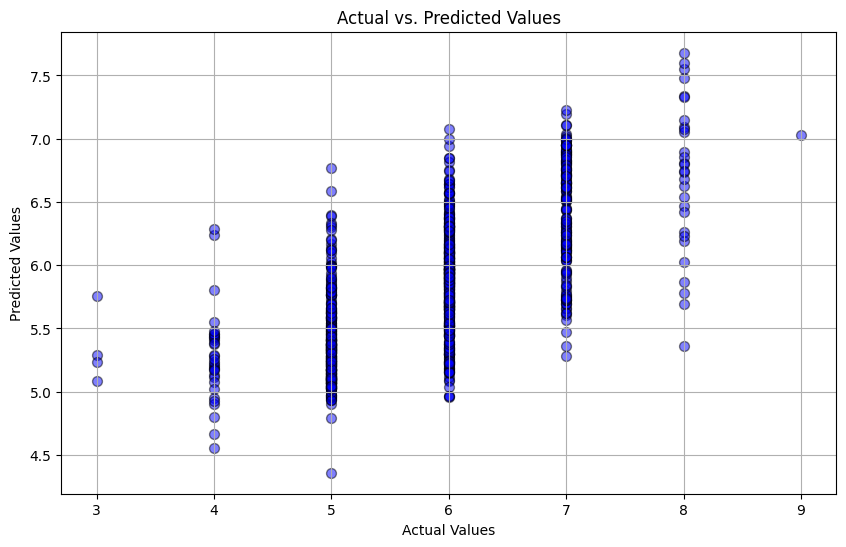

In [30]:
plot_predicted_actual_values(y_val,y_val_pred_rf)

### Provera parametara na toplotnoj mapi
S obzirom na to da imamo pet hiperparametara, projekcija ukupne toplotne mape na dva parametra nije dovoljno informativna. Umesto toplotnih mapa možemo koristiti metodu za iscrtavanje paralelnih koordinata. Ova metoda omogućava vizualizaciju više hiperparametara zajedno kako bi se lakše analizirale njihove interakcije i uticaj na performanse modela.

Takođe, s obzirom na to da je pretraga hiperparametara randomizovana, neke od vrednosti mogu biti nedostupne.

In [31]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

cv_results = pd.DataFrame(grid_search_rf.cv_results_)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

df = cv_results.rename(columns=shorten_param)

fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['mean_test_score'],
            colorscale='Viridis',
            showscale=True
        ),
        dimensions = list([
            dict(range = [50,300],
                label = 'n_estimators', values = df['n_estimators']),
            dict(range= [0,100],
                 label='max_depth', values = df['max_depth']),
            dict(range = [2,10],
                label = 'min_samples_split', values = df['min_samples_split']),
            dict(range = [1,4],
                label = 'min_samples_leaf', values = df['min_samples_leaf'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [32]:
# Testiranje dobijenog modela na validacionom skupu
print("Random Forest model errors on validation set: ")
model_rf = print_errors(y_val,y_val_pred_rf,'RF')
models = models + [model_rf]

Random Forest model errors on validation set: 
Mean Squared Error:  0.39636120521941354
Mean Absolute Error:  0.46498664002664003
Root Mean Squared Error:  0.6295722398735617
R-squared:  0.47843528078842223
Median Absolute Error:  0.3448333333333329
Explained Variance Score:  0.47871530895086656
Mean Absolute Percentage Error: 8.29%


## Adaboost

In [33]:
# Hiperparametri
pipeline_ab = Pipeline([
    ('scalar',StandardScaler()),
    ('pca', PCA()),
    ('regressor', AdaBoostRegressor())
])

param_grid_ab = {
    'pca__n_components': [8, 9, 10, 11],
    'regressor__n_estimators': [10, 100, 1000, 5000, 10000],  # Number of boosting stages
    'regressor__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],  # Learning rate shrinks the contribution of each tree
}

In [37]:
# Unakrsna validacija
grid_search_ab = model_selection.GridSearchCV(pipeline_ab, param_grid_ab, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ab.fit(X_train, y_train)
best_model_ab = grid_search_ab.best_score_

print("Best cross-validation score for Adaboost: ",best_model_ab)
print("Best parameters for AdaBoost: ", grid_search_ab.best_params_)

Best cross-validation score for Adaboost:  -0.568149919831528
Best parameters for AdaBoost:  {'pca__n_components': 9, 'regressor__learning_rate': 0.001, 'regressor__n_estimators': 10000}


In [38]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_ab = grid_search_ab.best_estimator_
y_val_pred_ab = best_model_ab.predict(X_val)

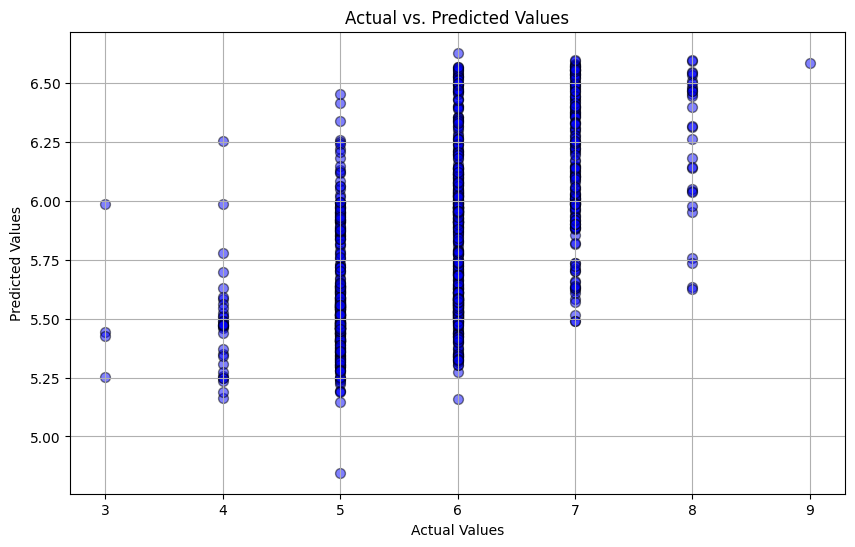

In [39]:
plot_predicted_actual_values(y_val,y_val_pred_ab)

### Provera parametara na toplotnoj mapi
Možemo da koristimo toplotne mape da se uverimo da pretražujemo dobre skupove parametara. Iz ovih rezultata vidimo da možemo pretraživati i veće vrednosti za *regressor__n_estimators* parametar.

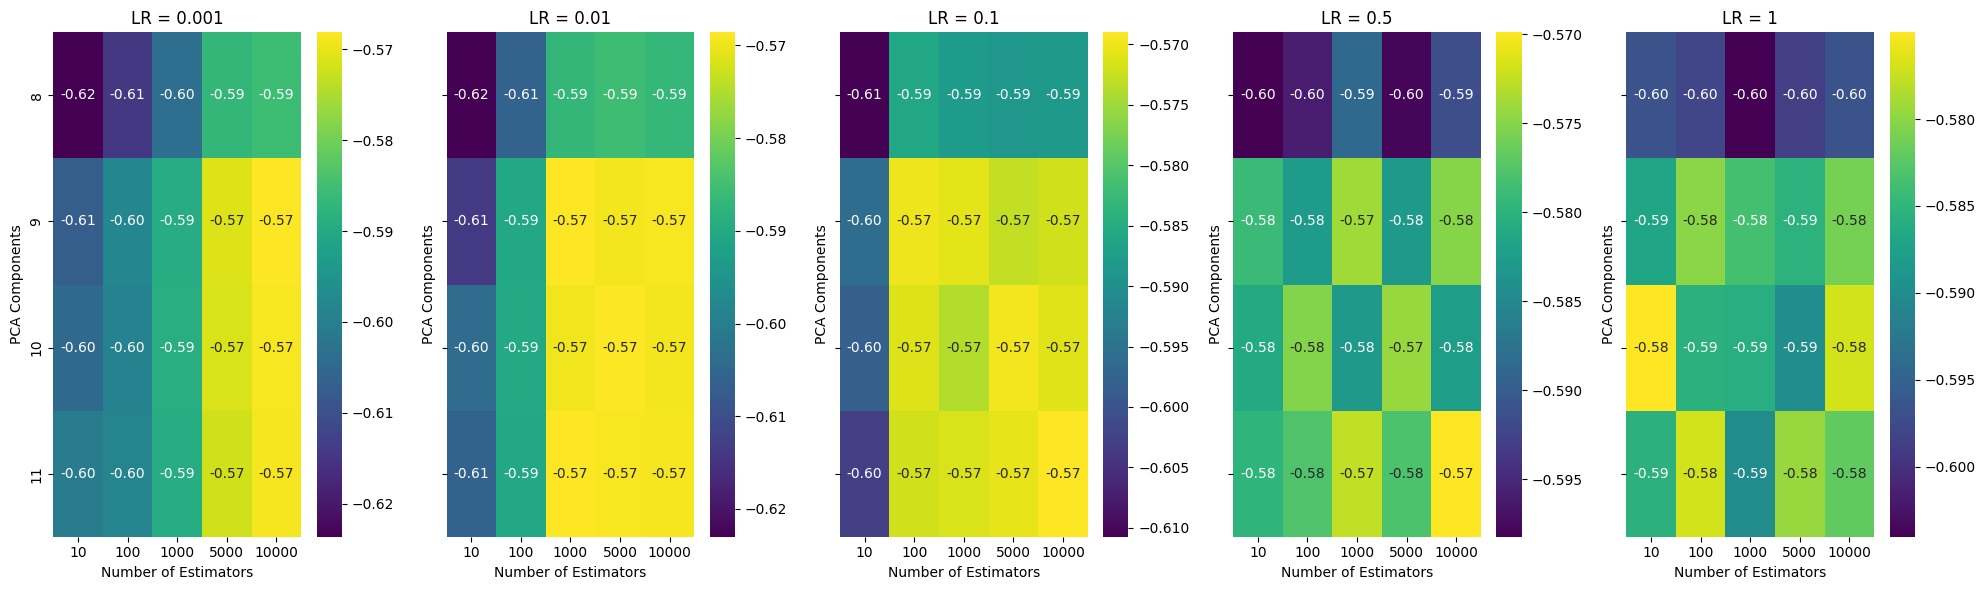

In [40]:
cv_results = pd.DataFrame(grid_search_ab.cv_results_)

cv_test_score = cv_results['mean_test_score'].values.reshape(5,5,4)

n_components = [8, 9, 10, 11]
n_estimators = [10, 100, 1000, 5000, 10000]
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]

fig, axs = plt.subplots(nrows=1, ncols=len(learning_rates), figsize=(20, 6), sharey=True)

# Iscrtavanje toplotnih mapa
for i, lr in enumerate(learning_rates):
    scores = cv_results[cv_results['param_regressor__learning_rate'] == lr]['mean_test_score'].values
    scores = scores.reshape(len(n_components), len(n_estimators))

    sb.heatmap(scores, xticklabels=n_estimators, yticklabels=n_components, cmap='viridis', annot=True, fmt='.2f', ax=axs[i])
    axs[i].set_xlabel('Number of Estimators')
    axs[i].set_ylabel('PCA Components')
    axs[i].set_title(f'LR = {lr}')

# Adjust layout
plt.tight_layout()
plt.show()

In [41]:
# Testiranje dobijenog modela na validacionom skupu
print("AdaBoost model errors on validation set: ")
model_ab = print_errors(y_val,y_val_pred_ab, 'AB')
models = models + [model_ab]

AdaBoost model errors on validation set: 
Mean Squared Error:  0.5219169609036896
Mean Absolute Error:  0.5784319385709529
Root Mean Squared Error:  0.7224382055952534
R-squared:  0.31321867634648104
Median Absolute Error:  0.4822274881516586
Explained Variance Score:  0.31327485384950116
Mean Absolute Percentage Error: 10.30%


## Izbor i testiranje najboljeg modela

Sada uporedimo greške svih korišćenih metoda kako bismo izabrali finalni model koji će biti testiran na test skupu.

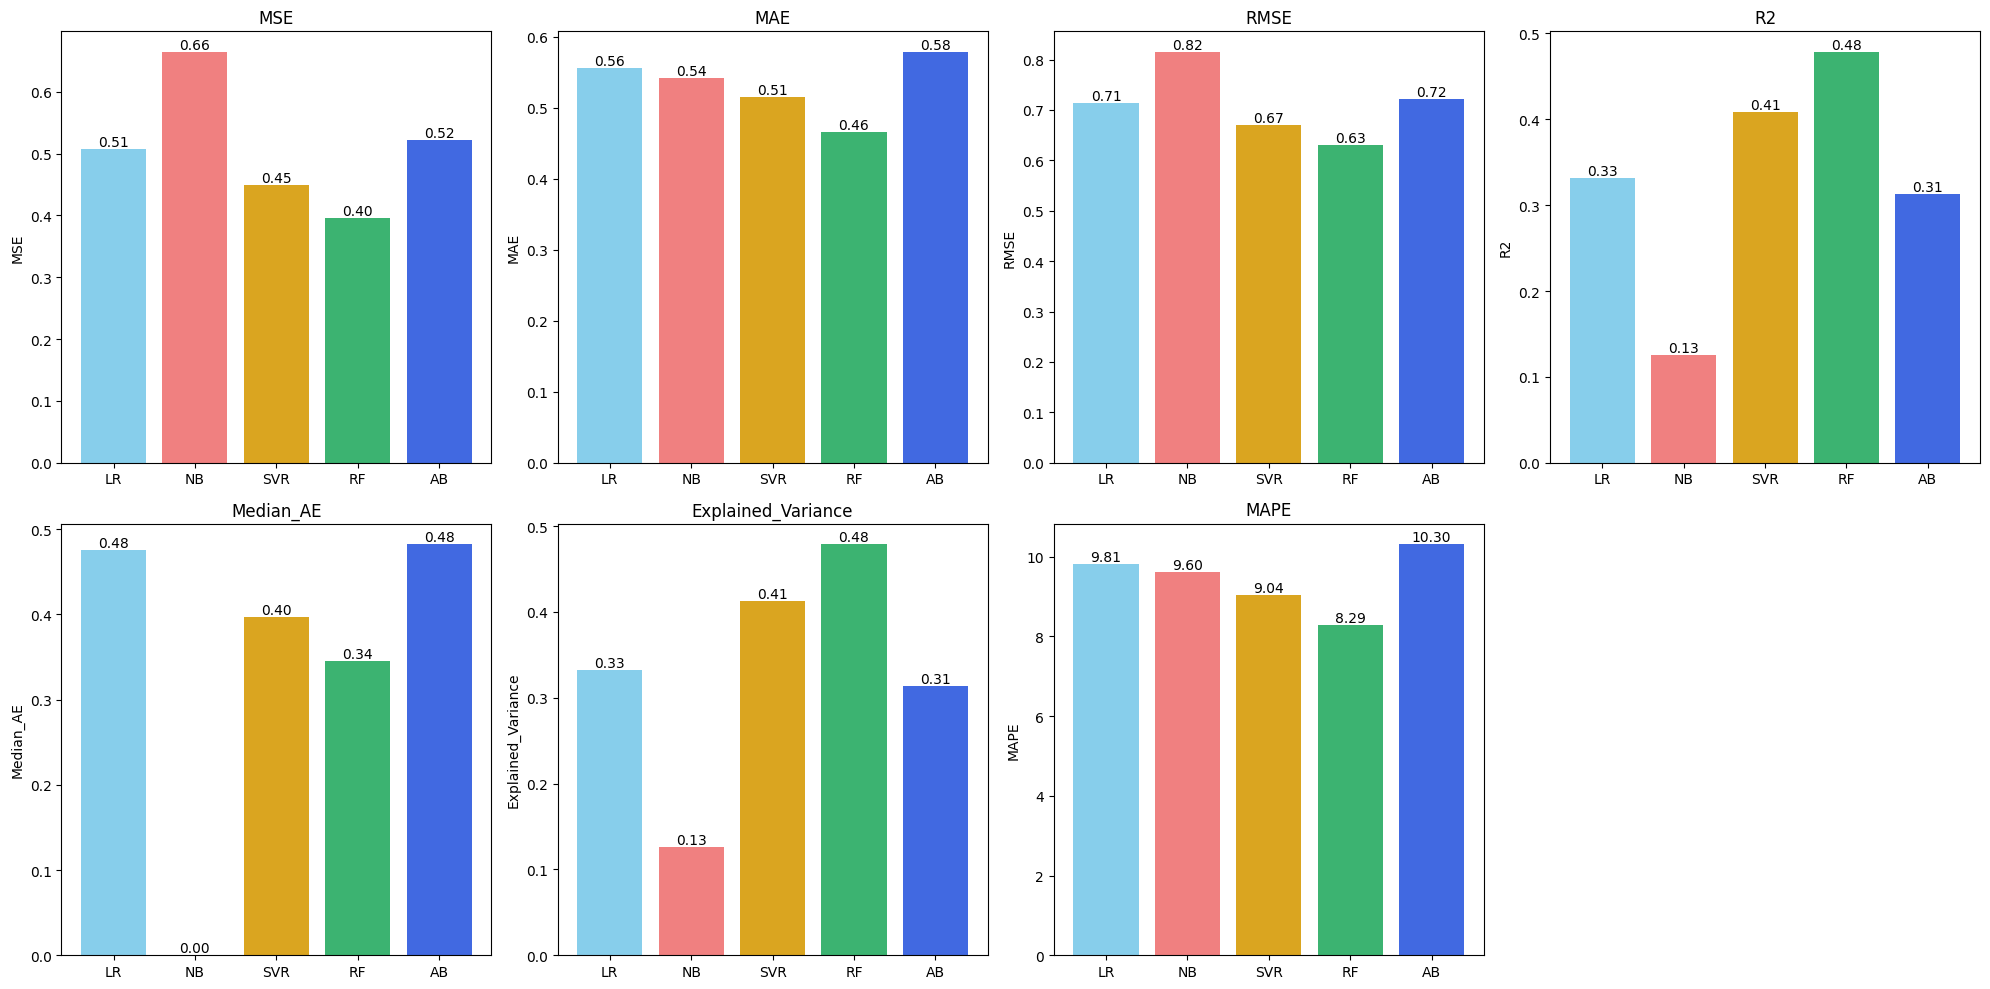

In [42]:
metric_names = ['MSE', 'MAE', 'RMSE', 'R2', 'Median_AE', 'Explained_Variance', 'MAPE']

model_names = [model["Model"] for model in models]
metric_values = {metric: [model[metric] for model in models] for metric in metric_names}

colors = [
    "skyblue",
    "lightcoral",
    "goldenrod",
    "mediumseagreen",
    "royalblue"
]

# Kreireamo histogram za svaku metriku
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, metric in enumerate(metric_names):
    row = i // 4
    col = i % 4

    bars = axs[row, col].bar(model_names, metric_values[metric], color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel(metric)

    # Tekst iznad barova
    for bar in bars:
        height = bar.get_height()
        axs[row, col].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

axs[1, 3].axis('off')

plt.tight_layout()
plt.show()

Zaključujemo da metoda slučajne šume postiže najbolje rezultate na validacionom skupu u svim metrikama koje smo koristili. Stoga ćemo ovaj model izabrati kao finalni. Sledeći korak je da ponovo obučimo model koristeći objedinjeni trening i validacioni skup, a zatim ćemo ga evaluirati na test skupu

In [43]:
# Standardizacija podataka koristeći uniju trening i validacionog skupa
final_scaler = StandardScaler()
X_train_validation = final_scaler.fit_transform(X_train_validation)
X_test = final_scaler.transform(X_test)

In [44]:
# Retreniranje najboljeg modela koristeci uniju skupova za trening i validaciju
best_model = best_model_rf
best_model.fit(X_train_validation,y_train_validation)

Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=9)),
                ('regressor',
                 RandomForestRegressor(min_samples_leaf=2, n_estimators=300))])

In [45]:
# Predikcija ciljne promenljive na test skupu koristeći finalni model
y_test_pred = best_model.predict(X_test)

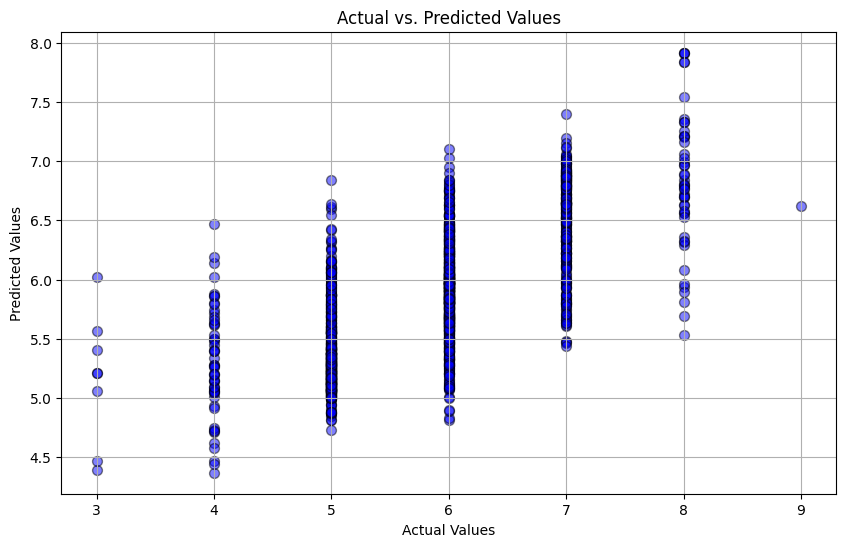

In [46]:
plot_predicted_actual_values(y_test,y_test_pred)

In [47]:
# Testiranje finalong modela na test skupu
print("Final model errors on validation set: ")
model_final = print_errors(y_test,y_test_pred, 'Final model')
models = models + [model_final]

Final model errors on validation set: 
Mean Squared Error:  0.3802154461249912
Mean Absolute Error:  0.4520477340721956
Root Mean Squared Error:  0.616616125417582
R-squared:  0.5014730224028823
Median Absolute Error:  0.3347777777777772
Explained Variance Score:  0.5023755534693541
Mean Absolute Percentage Error: 8.16%


## Čuvanje finalnog modela

In [53]:
model_filename='wine_quality.model'

In [54]:
with open(model_filename, 'wb') as pickle_file:
    pickle.dump(best_model,pickle_file)

In [56]:
scaler_filename='wine_quality.scaler'

In [57]:
with open(scaler_filename, 'wb') as pickle_file:
    pickle.dump(scaler,pickle_file)